# __Project 3a: Advanced GAN Crystal Ball__

In [1]:
# Basic Libraries
import scipy.io
import pandas as pd
import numpy as np
import matplotlib as plt
import datetime
from PIL import Image
import os

# Torch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchgan.models as models
from torchvision.utils import save_image
import torchvision.utils as vutils

from torchmetrics.image.inception import InceptionScore
from pytorch_fid import fid_score

print(dir(models))
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
else:
    print('cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

['ACGANDiscriminator', 'ACGANGenerator', 'AutoEncodingDiscriminator', 'AutoEncodingGenerator', 'ConditionalGANDiscriminator', 'ConditionalGANGenerator', 'DCGANDiscriminator', 'DCGANGenerator', 'Discriminator', 'Generator', 'InfoGANDiscriminator', 'InfoGANGenerator', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'acgan', 'autoencoding', 'conditional', 'dcgan', 'infogan', 'model']
NVIDIA GeForce RTX 4060 Laptop GPU


### __Download__ and __Extract__ the CelebA Dataset

In [2]:
#!curl -L https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar -o wiki_crop.tar

In [3]:
#!tar -xvzf wiki_crop.tar -C .

### __Load the Celeb-WIKI Dataset__

In [4]:
mat_file_path = './wiki_crop/wiki.mat'
mat = scipy.io.loadmat(mat_file_path)

mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'wiki'])

In [5]:
mat.items()

dict_items([('__header__', b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Jan 16 16:25:20 2016'), ('__version__', '1.0'), ('__globals__', []), ('wiki', array([[(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]]), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
                array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
                array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
                array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
                array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
                array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
              dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
                array(['Dettmar Cramer'], dtype='<U14'),
                array(['Marc Okrand'], dtype='<U11'), ...,
                array(['Mi

In [6]:
# Extract from .mat file
wiki = mat['wiki']

full_path = wiki['full_path'][0][0][0]
gender = wiki['gender'][0][0][0]
dob = wiki['dob'][0][0][0]
photo_taken = wiki['photo_taken'][0][0][0]
face_location = wiki['face_location'][0][0][0]
name = wiki['name'][0][0][0]
face_score = wiki['face_score'][0][0][0]
second_face_score = wiki['second_face_score'][0][0][0]

df = pd.DataFrame({
    'full_path': full_path,
    'gender': gender.flatten(),
    'dob': dob.flatten(),
    'photo_taken': photo_taken.flatten(),
    'face_location': face_location.tolist(),
    'name': name.flatten(),
    'face_score': face_score.flatten(),
    'second_face_score': second_face_score.flatten()
})

### __Data Cleaning__

In [7]:
# -inf for face score means that the confidence of a face being detected in the image is virtually NONEXISTENT!
num_neg_inf = (df['face_score'] == -np.inf).sum()
print(num_neg_inf)
df_filtered = df[df['face_score'] != -np.inf]
df_filtered

18016


,full_path,gender,dob,photo_taken,face_location,name,face_score,second_face_score
0,[17/10000217_1981-05-05_2009.jpg],1.0,723671,2009,"[[111.29109473290997, 111.29109473290997, 252....",[Sami Jauhojärvi],4.300962,NaN
1,[48/10000548_1925-04-04_1964.jpg],1.0,703186,1964,"[[252.48330229530742, 126.68165114765371, 354....",[Dettmar Cramer],2.645639,1.949248
2,[12/100012_1948-07-03_2008.jpg],1.0,711677,2008,"[[113.52, 169.83999999999997, 366.08, 422.4]]",[Marc Okrand],4.329329,NaN
4,[16/10002116_1971-05-31_2012.jpg],0.0,720044,2012,"[[171.61031405173117, 75.57451239763239, 266.7...",[Diana Damrau],3.408442,NaN
5,[02/10002702_1960-11-09_2012.jpg],0.0,716189,2012,"[[274.76563240288175, 57.7700900839337, 376.88...",[Krista Tippett],4.748056,NaN
...,...,...,...,...,...,...,...,...
62321,[38/9996938_1937-02-15_1968.jpg],1.0,707521,1968,"[[83.1122019227873, 83.1122019227873, 329.2488...",[Coen Moulijn],3.868307,NaN
62322,[46/9996946_1943-11-01_1968.jpg],1.0,709971,1968,"[[123.45351931209424, 196.99763089935078, 343....",[Theo van Duivenbode],3.735573,NaN
62323,[49/9996949_1937-04-17_1963.jpg],1.0,707582,1963,"[[128.92773553879837, 128.92773553879837, 320....",[Guus Haak],4.029268,NaN
62325,[09/9998109_1972-12-27_2013.jpg],1.0,720620,2013,"[[169.88839785556354, 74.31669471981023, 235.2...",[Michael Wiesinger],3.494303,NaN


In [8]:
num_nans = df_filtered['second_face_score'].isna().sum()
df_filtered = df_filtered[df_filtered['second_face_score'].isna()]
df_filtered

,full_path,gender,dob,photo_taken,face_location,name,face_score,second_face_score
0,[17/10000217_1981-05-05_2009.jpg],1.0,723671,2009,"[[111.29109473290997, 111.29109473290997, 252....",[Sami Jauhojärvi],4.300962,NaN
2,[12/100012_1948-07-03_2008.jpg],1.0,711677,2008,"[[113.52, 169.83999999999997, 366.08, 422.4]]",[Marc Okrand],4.329329,NaN
4,[16/10002116_1971-05-31_2012.jpg],0.0,720044,2012,"[[171.61031405173117, 75.57451239763239, 266.7...",[Diana Damrau],3.408442,NaN
5,[02/10002702_1960-11-09_2012.jpg],0.0,716189,2012,"[[274.76563240288175, 57.7700900839337, 376.88...",[Krista Tippett],4.748056,NaN
6,[41/10003541_1937-09-27_1971.jpg],1.0,707745,1971,"[[79.35580188693945, 26.65993396231315, 197.60...",[Bernie Whitebear],4.184828,NaN
...,...,...,...,...,...,...,...,...
62321,[38/9996938_1937-02-15_1968.jpg],1.0,707521,1968,"[[83.1122019227873, 83.1122019227873, 329.2488...",[Coen Moulijn],3.868307,NaN
62322,[46/9996946_1943-11-01_1968.jpg],1.0,709971,1968,"[[123.45351931209424, 196.99763089935078, 343....",[Theo van Duivenbode],3.735573,NaN
62323,[49/9996949_1937-04-17_1963.jpg],1.0,707582,1963,"[[128.92773553879837, 128.92773553879837, 320....",[Guus Haak],4.029268,NaN
62325,[09/9998109_1972-12-27_2013.jpg],1.0,720620,2013,"[[169.88839785556354, 74.31669471981023, 235.2...",[Michael Wiesinger],3.494303,NaN


In [9]:
num_nans = df_filtered['gender'].isna().sum()
df_filtered = df_filtered[df_filtered['gender'].notna()]
num_nans = df_filtered['gender'].isna().sum()
print(num_nans)
df_filtered

0


,full_path,gender,dob,photo_taken,face_location,name,face_score,second_face_score
0,[17/10000217_1981-05-05_2009.jpg],1.0,723671,2009,"[[111.29109473290997, 111.29109473290997, 252....",[Sami Jauhojärvi],4.300962,NaN
2,[12/100012_1948-07-03_2008.jpg],1.0,711677,2008,"[[113.52, 169.83999999999997, 366.08, 422.4]]",[Marc Okrand],4.329329,NaN
4,[16/10002116_1971-05-31_2012.jpg],0.0,720044,2012,"[[171.61031405173117, 75.57451239763239, 266.7...",[Diana Damrau],3.408442,NaN
5,[02/10002702_1960-11-09_2012.jpg],0.0,716189,2012,"[[274.76563240288175, 57.7700900839337, 376.88...",[Krista Tippett],4.748056,NaN
6,[41/10003541_1937-09-27_1971.jpg],1.0,707745,1971,"[[79.35580188693945, 26.65993396231315, 197.60...",[Bernie Whitebear],4.184828,NaN
...,...,...,...,...,...,...,...,...
62321,[38/9996938_1937-02-15_1968.jpg],1.0,707521,1968,"[[83.1122019227873, 83.1122019227873, 329.2488...",[Coen Moulijn],3.868307,NaN
62322,[46/9996946_1943-11-01_1968.jpg],1.0,709971,1968,"[[123.45351931209424, 196.99763089935078, 343....",[Theo van Duivenbode],3.735573,NaN
62323,[49/9996949_1937-04-17_1963.jpg],1.0,707582,1963,"[[128.92773553879837, 128.92773553879837, 320....",[Guus Haak],4.029268,NaN
62325,[09/9998109_1972-12-27_2013.jpg],1.0,720620,2013,"[[169.88839785556354, 74.31669471981023, 235.2...",[Michael Wiesinger],3.494303,NaN


In [10]:
df_filtered = df_filtered.drop(columns=['second_face_score'])
df_filtered

,full_path,gender,dob,photo_taken,face_location,name,face_score
0,[17/10000217_1981-05-05_2009.jpg],1.0,723671,2009,"[[111.29109473290997, 111.29109473290997, 252....",[Sami Jauhojärvi],4.300962
2,[12/100012_1948-07-03_2008.jpg],1.0,711677,2008,"[[113.52, 169.83999999999997, 366.08, 422.4]]",[Marc Okrand],4.329329
4,[16/10002116_1971-05-31_2012.jpg],0.0,720044,2012,"[[171.61031405173117, 75.57451239763239, 266.7...",[Diana Damrau],3.408442
5,[02/10002702_1960-11-09_2012.jpg],0.0,716189,2012,"[[274.76563240288175, 57.7700900839337, 376.88...",[Krista Tippett],4.748056
6,[41/10003541_1937-09-27_1971.jpg],1.0,707745,1971,"[[79.35580188693945, 26.65993396231315, 197.60...",[Bernie Whitebear],4.184828
...,...,...,...,...,...,...,...
62321,[38/9996938_1937-02-15_1968.jpg],1.0,707521,1968,"[[83.1122019227873, 83.1122019227873, 329.2488...",[Coen Moulijn],3.868307
62322,[46/9996946_1943-11-01_1968.jpg],1.0,709971,1968,"[[123.45351931209424, 196.99763089935078, 343....",[Theo van Duivenbode],3.735573
62323,[49/9996949_1937-04-17_1963.jpg],1.0,707582,1963,"[[128.92773553879837, 128.92773553879837, 320....",[Guus Haak],4.029268
62325,[09/9998109_1972-12-27_2013.jpg],1.0,720620,2013,"[[169.88839785556354, 74.31669471981023, 235.2...",[Michael Wiesinger],3.494303


In [11]:
def matlab_serial_to_year(serial_date):
    # MATLAB's serial dates start from 0000-01-01, Python starts from 0001-01-01
    origin = datetime.datetime(1, 1, 1)  # Using year 1
    delta = datetime.timedelta(days=int(serial_date) - 366)  # Subtract 366 to adjust MATLAB's start year (0)
    return (origin + delta).year

# Assuming your cleaned DataFrame is named 'df'
def get_age_bucket(age):
    if age <= 18:
        return 1
    elif 19 <= age <= 29:
        return 2
    elif 30 <= age <= 39:
        return 3
    elif 40 <= age <= 49:
        return 4
    elif 50 <= age <= 59:
        return 5
    else:
        return 6

final_df = df_filtered.copy()
final_df['dob'] = df_filtered['dob'].apply(matlab_serial_to_year)

# Add another feature
final_df['age'] = final_df['photo_taken'] - final_df['dob']
final_df = final_df.drop(columns=['dob', 'photo_taken'])

# Assign age bucket to each row
final_df['age_bucket'] = final_df['age'].apply(get_age_bucket)

# Add './wiki_crop/' prefix to the full_path column to get the correct paths
final_df['full_path'] = final_df['full_path'].apply(lambda x: f"./wiki_crop/{x[0]}")

# Convert gender to int
final_df['gender'] = final_df['gender'].astype(int)

# Check the updated DataFrame
final_df

,full_path,gender,face_location,name,face_score,age,age_bucket
0,./wiki_crop/17/10000217_1981-05-05_2009.jpg,1,"[[111.29109473290997, 111.29109473290997, 252....",[Sami Jauhojärvi],4.300962,28,2
2,./wiki_crop/12/100012_1948-07-03_2008.jpg,1,"[[113.52, 169.83999999999997, 366.08, 422.4]]",[Marc Okrand],4.329329,60,6
4,./wiki_crop/16/10002116_1971-05-31_2012.jpg,0,"[[171.61031405173117, 75.57451239763239, 266.7...",[Diana Damrau],3.408442,41,4
5,./wiki_crop/02/10002702_1960-11-09_2012.jpg,0,"[[274.76563240288175, 57.7700900839337, 376.88...",[Krista Tippett],4.748056,52,5
6,./wiki_crop/41/10003541_1937-09-27_1971.jpg,1,"[[79.35580188693945, 26.65993396231315, 197.60...",[Bernie Whitebear],4.184828,34,3
...,...,...,...,...,...,...,...
62321,./wiki_crop/38/9996938_1937-02-15_1968.jpg,1,"[[83.1122019227873, 83.1122019227873, 329.2488...",[Coen Moulijn],3.868307,31,3
62322,./wiki_crop/46/9996946_1943-11-01_1968.jpg,1,"[[123.45351931209424, 196.99763089935078, 343....",[Theo van Duivenbode],3.735573,25,2
62323,./wiki_crop/49/9996949_1937-04-17_1963.jpg,1,"[[128.92773553879837, 128.92773553879837, 320....",[Guus Haak],4.029268,26,2
62325,./wiki_crop/09/9998109_1972-12-27_2013.jpg,1,"[[169.88839785556354, 74.31669471981023, 235.2...",[Michael Wiesinger],3.494303,41,4


In [12]:
final_df['face_location'] = final_df['face_location'].apply(lambda x: x[0].tolist() if isinstance(x, np.ndarray) and x.ndim == 2 else x)
final_df['name'] = final_df['name'].apply(lambda x: x[0] if isinstance(x, np.ndarray) and x.ndim == 1 else x)

print(final_df.dtypes)

final_df

full_path         object
gender             int32
face_location     object
name              object
face_score       float64
age                int64
age_bucket         int64
dtype: object


,full_path,gender,face_location,name,face_score,age,age_bucket
0,./wiki_crop/17/10000217_1981-05-05_2009.jpg,1,"[111.29109473290997, 111.29109473290997, 252.6...",Sami Jauhojärvi,4.300962,28,2
2,./wiki_crop/12/100012_1948-07-03_2008.jpg,1,"[113.52, 169.83999999999997, 366.08, 422.4]",Marc Okrand,4.329329,60,6
4,./wiki_crop/16/10002116_1971-05-31_2012.jpg,0,"[171.61031405173117, 75.57451239763239, 266.76...",Diana Damrau,3.408442,41,4
5,./wiki_crop/02/10002702_1960-11-09_2012.jpg,0,"[274.76563240288175, 57.7700900839337, 376.886...",Krista Tippett,4.748056,52,5
6,./wiki_crop/41/10003541_1937-09-27_1971.jpg,1,"[79.35580188693945, 26.65993396231315, 197.609...",Bernie Whitebear,4.184828,34,3
...,...,...,...,...,...,...,...
62321,./wiki_crop/38/9996938_1937-02-15_1968.jpg,1,"[83.1122019227873, 83.1122019227873, 329.24880...",Coen Moulijn,3.868307,31,3
62322,./wiki_crop/46/9996946_1943-11-01_1968.jpg,1,"[123.45351931209424, 196.99763089935078, 343.2...",Theo van Duivenbode,3.735573,25,2
62323,./wiki_crop/49/9996949_1937-04-17_1963.jpg,1,"[128.92773553879837, 128.92773553879837, 320.1...",Guus Haak,4.029268,26,2
62325,./wiki_crop/09/9998109_1972-12-27_2013.jpg,1,"[169.88839785556354, 74.31669471981023, 235.25...",Michael Wiesinger,3.494303,41,4


### __Data Preprocessing__

In [13]:
# Load the data
data = pd.read_csv('./final_data.csv')

# 1. Parse `face_location`
data['face_location'] = data['face_location'].apply(eval)

# 2. Verify Image Paths
valid_paths = data['full_path'].apply(lambda x: os.path.exists(x))
if not valid_paths.all():
    print(f"Invalid paths detected: {data[~valid_paths]}")
    data = data[valid_paths]

# 3. Prepare Conditions
# One-hot encode age_bucket
age_buckets = torch.eye(6)[data['age_bucket'] - 1]  # Zero-indexed buckets (1-6 -> 0-5)
# Gender as a tensor
genders = torch.tensor(data['gender'].values, dtype=torch.float32).unsqueeze(1)
# Combine age_bucket and gender
conditions = torch.cat((age_buckets, genders), dim=1)

# 4. Transform and Resize Images
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Preprocess images
images = []
valid_image_paths = []

for path in data['full_path']:
    try:
        img = Image.open(path).convert("RGB")
        img = transform(img)
        images.append(img)
        valid_image_paths.append(path)  # Keep track of valid paths
    except Exception as e:
        print(f"Error processing image {path}: {e}")

# Convert to tensors
images = torch.stack(images)

# Update the dataframe to include only valid image paths
data = data[data['full_path'].isin(valid_image_paths)]

print(f"Images Shape: {images.shape}")
print(f"Conditions Shape: {conditions.shape}")

Images Shape: torch.Size([39455, 3, 64, 64])
Conditions Shape: torch.Size([39455, 7])


### __Modeling__

In [14]:
import torch.nn.utils as nn_utils
class MyConditionalGenerator(nn.Module):
    def __init__(self, noise_dim, condition_dim, img_channels=3, img_size=64):
        super(MyConditionalGenerator, self).__init__()
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(noise_dim + condition_dim, 256 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, img_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((noise, labels), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 256, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [15]:
class MyConditionalDiscriminator(nn.Module):
    def __init__(self, condition_dim, img_channels=3, img_size=64):
        super(MyConditionalDiscriminator, self).__init__()
        self.img_size = img_size
        self.model = nn.Sequential(
            nn_utils.spectral_norm(nn.Conv2d(img_channels + condition_dim, 64, 4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn_utils.spectral_norm(nn.Conv2d(64, 128, 4, stride=2, padding=1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn_utils.spectral_norm(nn.Conv2d(128, 256, 4, stride=2, padding=1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn_utils.spectral_norm(nn.Conv2d(256, 512, 4, stride=2, padding=1)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(
            nn_utils.spectral_norm(nn.Linear(512 * ds_size ** 2, 1)),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Expand labels to have the same spatial dimensions as the image
        labels = labels.view(labels.size(0), labels.size(1), 1, 1)
        labels = labels.expand(labels.size(0), labels.size(1), self.img_size, self.img_size)
        d_in = torch.cat((img, labels), 1)
        out = self.model(d_in)
        out = out.view(out.size(0), -1)
        validity = self.adv_layer(out)
        return validity

In [16]:
from torch.utils.data import TensorDataset, DataLoader

# Combine images and conditions into a dataset
dataset = TensorDataset(images, conditions)

# Create a DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Check a batch
for batch_imgs, batch_conditions in dataloader:
    print(f"Batch Image Shape: {batch_imgs.shape}, Batch Condition Shape: {batch_conditions.shape}")
    break

Batch Image Shape: torch.Size([64, 3, 64, 64]), Batch Condition Shape: torch.Size([64, 7])


In [17]:
# Adjusted Hyperparameters
noise_dim = 100
condition_dim = conditions.shape[1]
epochs = 50
batch_size = 64
lr_G = 0.0002       # Lowered generator learning rate
lr_D = 0.00005      # Reduced discriminator learning rate
betas = (0.5, 0.999)
# Removed 'generator_steps' since we're training the generator once per iteration

generator = MyConditionalGenerator(noise_dim, condition_dim).to(device)
discriminator = MyConditionalDiscriminator(condition_dim).to(device)

# Loss and optimizers
loss_fn = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr_G, betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_D, betas=betas)

# Define fixed noise and conditions for visualization
fixed_noise = torch.randn(batch_size, noise_dim).to(device)
fixed_conds = conditions[:batch_size].to(device)  # Ensure batch_size samples

# Training Loop
for epoch in range(epochs):
    for real_imgs, conds in dataloader:
        real_imgs, conds = real_imgs.to(device), conds.to(device)
        conds_flat = conds.view(conds.size(0), -1)
        current_batch_size = real_imgs.size(0)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Generate fake images
        noise = torch.randn(current_batch_size, noise_dim).to(device)
        fake_imgs = generator(noise, conds_flat)

        # Real and fake labels with label smoothing
        real_labels = torch.full((current_batch_size, 1), 0.9).to(device)  # Real labels smoothed to 0.9
        fake_labels = torch.zeros(current_batch_size, 1).to(device)         # Fake labels at 0

        # Compute discriminator loss
        real_output = discriminator(real_imgs, conds_flat)
        fake_output = discriminator(fake_imgs.detach(), conds_flat)
        real_loss = loss_fn(real_output, real_labels)
        fake_loss = loss_fn(fake_output, fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        # Generate fake images
        noise = torch.randn(current_batch_size, noise_dim).to(device)
        fake_imgs = generator(noise, conds_flat)

        # Generator tries to fool discriminator
        output = discriminator(fake_imgs, conds_flat)
        g_loss = loss_fn(output, real_labels)
        g_loss.backward()
        optimizer_G.step()

    # Save generated images for visualization
    with torch.no_grad():
        fake_imgs = generator(fixed_noise, fixed_conds)
        vutils.save_image(fake_imgs, f'generated_epoch_{epoch+1}.png', normalize=True)

    # Print progress
    print(f"Epoch [{epoch + 1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch [1/50] | D Loss: 0.6531 | G Loss: 0.9603
Epoch [2/50] | D Loss: 0.6111 | G Loss: 0.8574
Epoch [3/50] | D Loss: 0.6708 | G Loss: 0.7221
Epoch [4/50] | D Loss: 0.7519 | G Loss: 0.8643
Epoch [5/50] | D Loss: 0.6548 | G Loss: 0.7319
Epoch [6/50] | D Loss: 0.6604 | G Loss: 0.9834
Epoch [7/50] | D Loss: 0.5890 | G Loss: 1.1231
Epoch [8/50] | D Loss: 0.6096 | G Loss: 1.3694
Epoch [9/50] | D Loss: 0.5275 | G Loss: 1.2952
Epoch [10/50] | D Loss: 0.4518 | G Loss: 1.4506
Epoch [11/50] | D Loss: 0.6003 | G Loss: 1.4587
Epoch [12/50] | D Loss: 0.5455 | G Loss: 0.9760
Epoch [13/50] | D Loss: 0.6573 | G Loss: 0.7677
Epoch [14/50] | D Loss: 0.5653 | G Loss: 0.8017
Epoch [15/50] | D Loss: 0.4712 | G Loss: 1.5784
Epoch [16/50] | D Loss: 0.5007 | G Loss: 1.1454
Epoch [17/50] | D Loss: 0.4676 | G Loss: 1.1713
Epoch [18/50] | D Loss: 0.5387 | G Loss: 1.0049
Epoch [19/50] | D Loss: 0.6050 | G Loss: 0.7203
Epoch [20/50] | D Loss: 0.6451 | G Loss: 1.1091
Epoch [21/50] | D Loss: 0.4798 | G Loss: 1.5544
E

### __Testing__

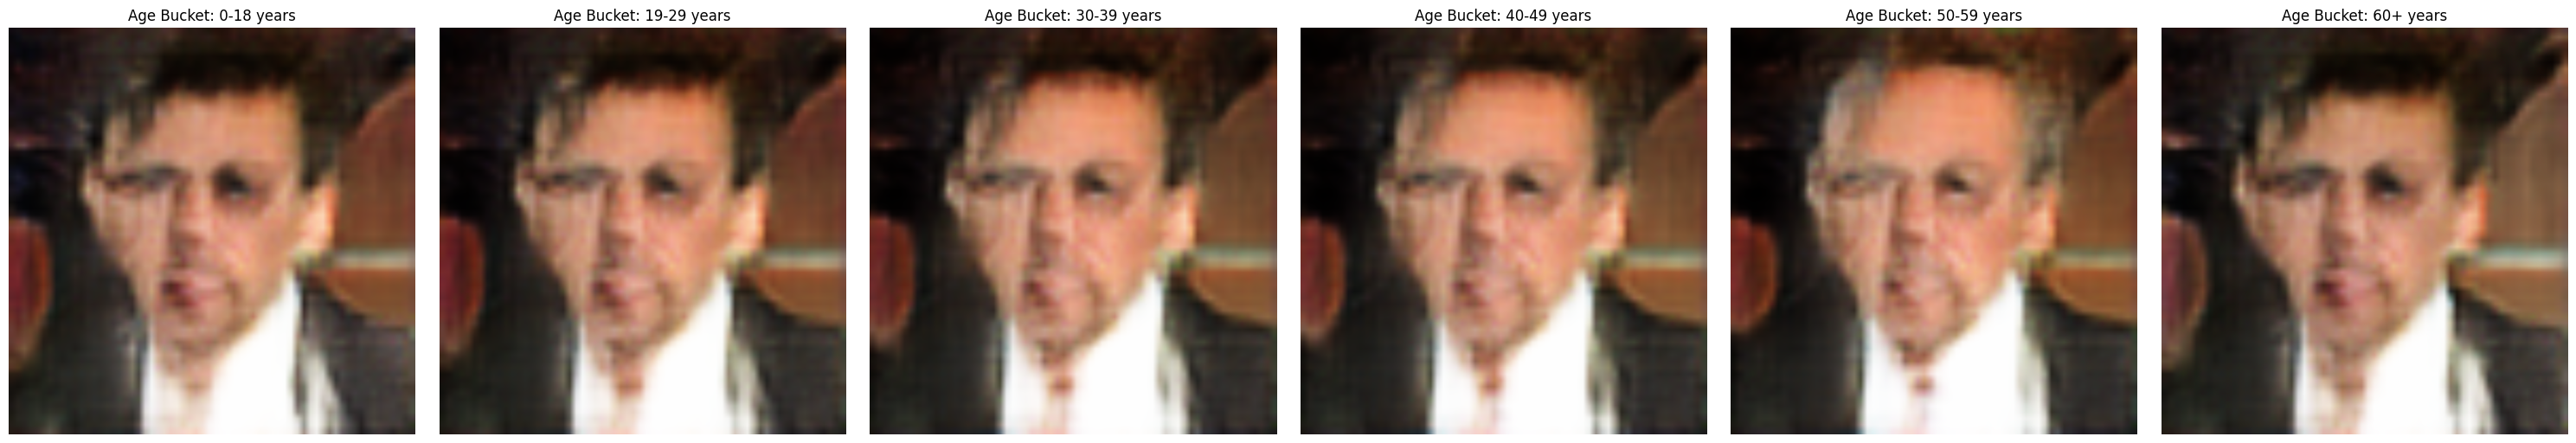

In [18]:
import torch
import random
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch.nn.functional as F

# Ensure your generator is in evaluation mode
generator.eval()

# 1. Select a Random Image and Extract Its Condition
# Get a random index from the dataset
random_idx = random.randint(0, len(dataset) - 1)

# Retrieve the condition (assuming you don't need the image itself)
_, random_condition = dataset[random_idx]

# Assuming the condition tensor is structured as [age_one_hot (6), gender (1)]
# Extract the gender condition
gender_condition = random_condition[-1:]  # Shape: [1]

# Convert to the appropriate device
gender_condition = gender_condition.to(device)

# 2. Fix a Noise Vector
fixed_noise = torch.randn(1, noise_dim).to(device)  # Shape: [1, noise_dim]

# List to hold generated images and corresponding age buckets
generated_images = []
age_buckets_list = []

# Upscale factor (e.g., upscale from 64x64 to 256x256)
upscale_factor = 10  # Adjust as needed

# Define age bucket labels (optional, for more informative titles)
age_bucket_labels = {
    1: '0-18 years',
    2: '19-29 years',
    3: '30-39 years',
    4: '40-49 years',
    5: '50-59 years',
    6: '60+ years'
}

# 3. Generate Images with Different Age Conditions
with torch.no_grad():
    for age_bucket in range(1, 7):  # Age buckets from 1 to 6
        # Create one-hot encoding for the current age bucket
        age_one_hot = torch.zeros(1, 6).to(device)  # Shape: [1, 6]
        age_one_hot[0, age_bucket - 1] = 1.0

        # Combine age_one_hot and gender_condition to form the condition tensor
        condition = torch.cat((age_one_hot, gender_condition.unsqueeze(0)), dim=1)  # Shape: [1, 7]

        # Generate image using the generator
        fake_img = generator(fixed_noise, condition)

        # Upscale the generated image
        fake_img_upscaled = F.interpolate(fake_img, scale_factor=upscale_factor, mode='bilinear', align_corners=False)

        # Append the generated image and age bucket to the lists
        generated_images.append(fake_img_upscaled.cpu().squeeze(0))
        age_buckets_list.append(age_bucket)

# 4. Visualize the Generated Images
num_images = len(generated_images)
fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))

# Handle the case when there's only one image (axes would not be a list)
if num_images == 1:
    axes = [axes]

for idx, ax in enumerate(axes):
    img = generated_images[idx]
    age_bucket = age_buckets_list[idx]

    # Unnormalize the image if necessary (assuming images are normalized to [-1, 1])
    img = (img * 0.5) + 0.5  # Convert from [-1, 1] to [0, 1]

    # Convert from Tensor to NumPy array and transpose dimensions for plotting
    img = img.permute(1, 2, 0).numpy()

    ax.imshow(img)
    ax.axis('off')
    # Use age bucket label if defined, else just the bucket number
    if age_bucket_labels:
        ax.set_title(f'Age Bucket: {age_bucket_labels[age_bucket]}')
    else:
        ax.set_title(f'Age Bucket: {age_bucket}')

plt.tight_layout()
plt.show()

In [19]:
import os
from torchvision.utils import save_image

# Directories to save images
generated_images_dir = 'generated_images'
os.makedirs(generated_images_dir, exist_ok=True)

# Number of images to generate
num_images = 10000  # Adjust as needed
batch_size = 64     # Adjust based on your GPU memory

# Set generator to evaluation mode
generator.eval()

# Function to sample random conditions (adjusted to match your first code)
def sample_random_conditions(batch_size):
    # Sample random age buckets from 1 to 6
    age_buckets = torch.randint(1, 7, (batch_size,))  # Age buckets: [1, 6]
    
    # Adjust age buckets to zero-based indexing for one-hot encoding
    age_buckets_zero_indexed = age_buckets - 1  # Age buckets: [0, 5]
    
    # One-hot encode age buckets
    age_buckets_one_hot = torch.nn.functional.one_hot(age_buckets_zero_indexed, num_classes=6).float()
    
    # Sample random genders (0 or 1)
    genders = torch.randint(0, 2, (batch_size, 1)).float()
    
    # Combine conditions
    conditions = torch.cat((age_buckets_one_hot, genders), dim=1)
    return conditions

# Generate and save images
with torch.no_grad():
    for i in range(0, num_images, batch_size):
        current_batch_size = min(batch_size, num_images - i)
        noise = torch.randn(current_batch_size, noise_dim).to(device)
        conds = sample_random_conditions(current_batch_size).to(device)
        fake_imgs = generator(noise, conds)
        
        # Denormalize images from [-1, 1] to [0, 1]
        fake_imgs = (fake_imgs + 1) / 2
        
        for j in range(current_batch_size):
            save_image(fake_imgs[j], os.path.join(generated_images_dir, f'gen_{i + j}.png'), normalize=False)

In [20]:
import os
from torchvision.utils import save_image

real_images_dir = 'real_images'
os.makedirs(real_images_dir, exist_ok=True)

# Number of real images to save (should match the number of generated images)
num_real_images = num_images  # Ensure 'num_images' is defined elsewhere

images_saved = 0

# Assuming you have a DataLoader 'dataloader' for your dataset
for real_imgs, _ in dataloader:
    real_imgs = real_imgs.to(device)

    # Denormalize images from [-1, 1] to [0, 1]
    real_imgs = (real_imgs + 1) / 2

    for i in range(real_imgs.size(0)):
        if images_saved >= num_real_images:
            break
        save_image(real_imgs[i], os.path.join(real_images_dir, f'real_{images_saved}.png'), normalize=False)
        images_saved += 1

    if images_saved >= num_real_images:
        break

In [21]:
from pytorch_fid import fid_score

# Compute FID
fid_value = fid_score.calculate_fid_given_paths(
    [real_images_dir, generated_images_dir],
    batch_size=64,
    device=device,
    dims=2048,
)
print(f'FID Score: {fid_value:.4f}')

100%|██████████| 157/157 [00:49<00:00,  3.19it/s]


FID Score: 55.6459


In [22]:
from torchmetrics.image.inception import InceptionScore
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Custom Dataset for Generated Images
class GeneratedImagesDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Transformation matching Inception model input
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.PILToTensor(),  # Converts to torch.uint8 in [0, 255] range
])

# Create DataLoader for generated images
dataset = GeneratedImagesDataset(generated_images_dir, transform=transform)
dataloader_IS = DataLoader(dataset, batch_size=32, shuffle=False)

# Initialize Inception Score metric
inception_metric = InceptionScore().to(device)

# Compute Inception Score
for batch in dataloader_IS:
    batch = batch.to(device)
    inception_metric.update(batch)

inception_score, std = inception_metric.compute()
print(f'Inception Score: {inception_score:.4f} ± {std:.4f}')

c:\Users\yashh\Downloads\aipi590-project-3a\.venv\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Inception Score: 3.1648 ± 0.0739
